<a href="https://colab.research.google.com/github/mjg-phys/cdm-computing-subgroup/blob/main/CDM_particleImageClassifier_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Particle image classifier

This notebook is originally from the SLAC Summer Institute and was one of the challenges of the intensity frontier. For more details see this [page](https://github.com/makagan/SSI_Projects/tree/main/if_projects).

This is a particle image classification problem. Four type of particles (electron, photon, muon, and proton) are simulated in liquid argon medium and the 2D projections of their 3D energy deposition patterns ("trajectories") are recorded. The challenge is to develop a classifier algorithm that identify which of four types is present in an image.

## Setting up

Pull the scripts for the project and download the data files. You only need to do this once per machine/instance you are using.

In [1]:
!pip install git+https://github.com/drinkingkazu/ssi_if
! download_if_dataset.py --challenge=image --flavor=train
! download_if_dataset.py --challenge=image --flavor=test

  Cloning https://github.com/drinkingkazu/ssi_if to /tmp/pip-req-build-arr12yk7
  Running command git clone --filter=blob:none --quiet https://github.com/drinkingkazu/ssi_if /tmp/pip-req-build-arr12yk7
  Resolved https://github.com/drinkingkazu/ssi_if to commit af38e2ce0730ec5a3091a849bee9e8e53d58042d
  Preparing metadata (setup.py) ... done
Downloading...
From (original): https://drive.google.com/uc?id=130Lm_4K2cCclnmOEZlVIBKKPkJUn3k3f
From (redirected): https://drive.google.com/uc?id=130Lm_4K2cCclnmOEZlVIBKKPkJUn3k3f&confirm=t&uuid=a1523452-7ee7-4a1a-8eaa-5d1c04021b6e
To: /content/if-image-train.h5
100% 550M/550M [00:06<00:00, 89.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1L2yjBkzL3Ruaf8HuaMDR5PC9nETG5t_i
From (redirected): https://drive.google.com/uc?id=1L2yjBkzL3Ruaf8HuaMDR5PC9nETG5t_i&confirm=t&uuid=f084f60b-15b7-457d-bb3b-2ffeaed24dc4
To: /content/if-image-test.h5
100% 138M/138M [00:00<00:00, 154MB/s]


and setting some global configurations including seeds (change as u see fit!) for reproducibility.

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True

import torch
torch.multiprocessing.set_start_method('spawn')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

import numpy as np
SEED=12345
_=np.random.seed(SEED)
_=torch.manual_seed(SEED)

cuda:0


## Data file contents

* A data file with 400,000 images for training: `train.h5`
  * ... which include 100,000 images per particle type
* A data file with 100,000 images for testing: `test.h5`
  * ... which include 25,000 images per particle type

These files are `HDF5` files and can be opened using `h5py`.


In [3]:
import h5py as h5
datapath='if-image-train.h5'

# Open a file in 'r'ead mode.
f=h5.File(datapath,mode='r',swmr=True)

# List items in the file
for key in f.keys():
    print('dataset',key,'... type',f[key].dtype,'... shape',f[key].shape)

dataset image ... type float32 ... shape (400000, 192, 192)
dataset index ... type int32 ... shape (400000,)
dataset mean ... type float64 ... shape (1,)
dataset pdg ... type int32 ... shape (400000,)
dataset std ... type float64 ... shape (1,)


... and let's visualize one image for fun!

PDG code 13


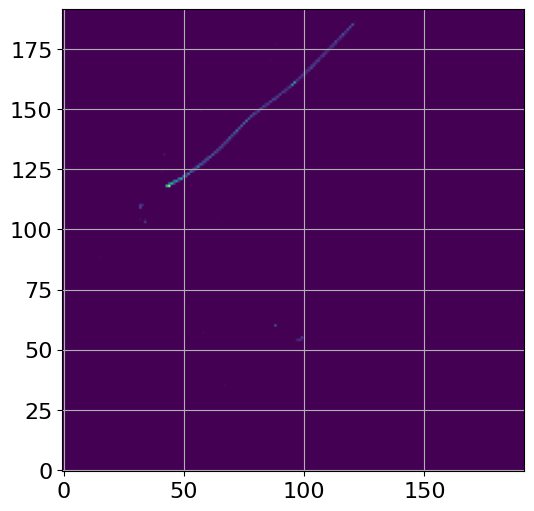

In [4]:
entry = 1

print('PDG code',f['pdg'][entry])
plt.imshow(f['image'][entry],origin='lower')
plt.show()

PDG code 13 means muon (if you are unfamiliar, "PDG code" is a signed integer as a unique identifier of a particle. See [this documentation](https://pdg.lbl.gov/2006/reviews/pdf-files/montecarlo-web.pdf) for more details.)

Let's don't forget to close the file :)

In [5]:
f.close()

## Particle Image `Dataset` and `DataLoader`

We prepared a simple torch `Dataset` implementation for this dataset.

In [6]:
from iftool.image_challenge import ParticleImage2D
train_data = ParticleImage2D(data_files=[datapath])

The dataset is index-accessible and produce a dictionary with four keys
* `data` ... 2D image of a particle (192x192 pixels)
* `pdg` ... PDG code of a particle. Should be [11,13,22,2212] = [electron,muon,photon,proton]
* `label` ... an integer label for classification
* `index` ... an index of the data entry from an input file

Size of dataset 400000
PDG code 13 ... label 1 

torch.Size([192, 192])


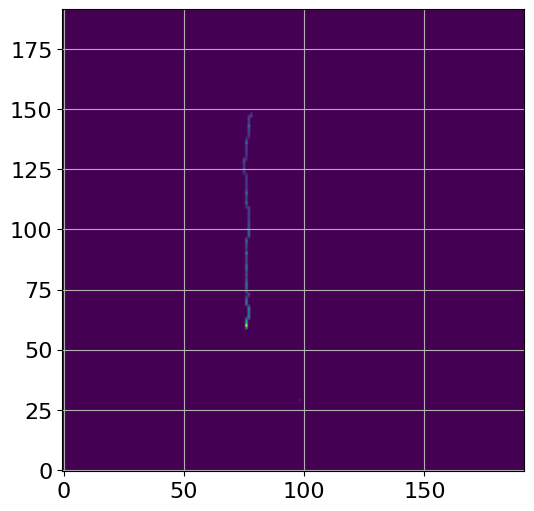

PDG code 11 ... label 0 

torch.Size([192, 192])


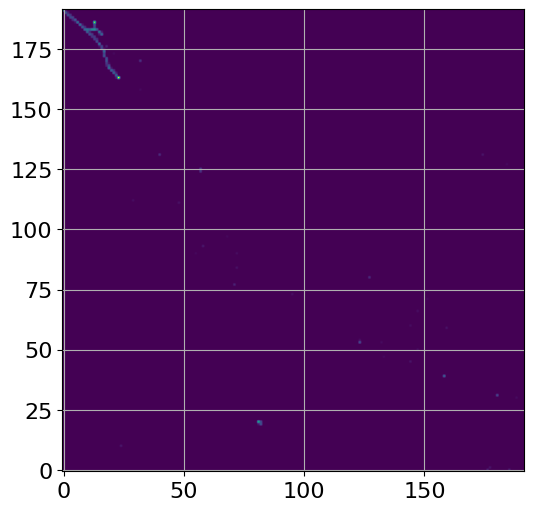

PDG code 22 ... label 2 

torch.Size([192, 192])


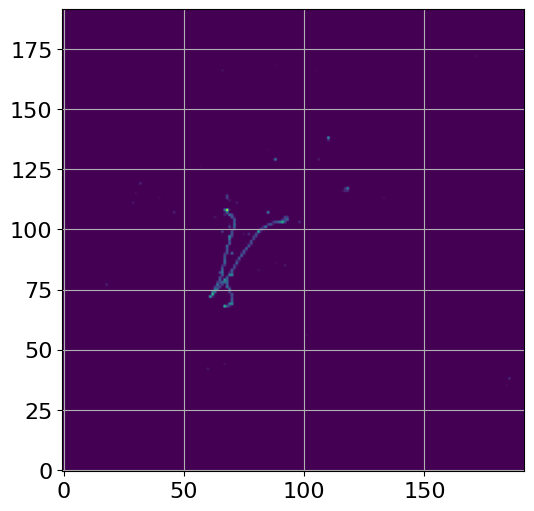

PDG code 2212 ... label 3 

torch.Size([192, 192])


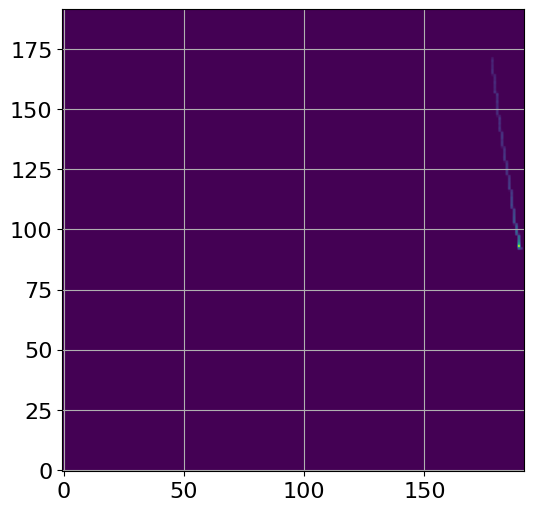

List of keys in a data element dict_keys(['data', 'label', 'pdg', 'index']) 



In [7]:
print('Size of dataset',len(train_data))

# 0  - 13, muon
# 3  - 11 , electron
# 12 - 22 , photon
# 4  - 2212, proton

all_types = [0,3,12,4]

# The data instance is a dictionary
# Visualize the image
for i in all_types:
  data = train_data[i]
  print('PDG code %d ... label %d \n' % (data['pdg'],data['label']))
  plt.imshow(data['data'],origin='lower')
  print(data['data'].size())
  plt.show()

print('List of keys in a data element',data.keys(),'\n')


Create a `DataLoader` instance in a usual way except we give a specifically designed collate function to handle a dictionary style data instance.

In [8]:
train_start = 0.0
train_end = 0.1
val_start = 0.1
val_end = 0.15
test_start = 0.15
test_end = 0.20

train_data = ParticleImage2D(data_files = [datapath],
                             start = train_start, # start of the dataset fraction to use. 0.0 = use from 1st entry
                             end   = train_end, # end of the dataset fraction to use. 1.0 = use up the last entry
                            )
val_data = ParticleImage2D(data_files = [datapath],
                             start = val_start, # start of the dataset fraction to use. 0.0 = use from 1st entry
                             end   = val_end, # end of the dataset fraction to use. 1.0 = use up the last entry
                            )


# We use a specifically designed "collate" function to create a batch data
from iftool.image_challenge import collate
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data,
                          collate_fn  = collate,
                          shuffle     = True,
                          num_workers = 2,
                          batch_size  = 100
                         )

val_loader = DataLoader(val_data,
                          collate_fn  = collate,
                          shuffle     = True,
                          num_workers = 2,
                          batch_size  = 100
                         )


Let's measure the speed of the dataloader

In [9]:
import time
tstart=time.time()
num_iter=100
ctr=num_iter
for batch in train_loader:
    ctr -=100
    if ctr <= 0: break
print((time.time()-tstart)/num_iter,'[s/iteration]')

0.05890665769577026 [s/iteration]


## Challenge

Here are open-ended challenge project for an image classification.

* Design a machine learning algorithm for performing image classification task. Report the performance (speed, memory, and classification accuracy) you achieved on the test set (remember, use the test set to only benchmark, don't use it for hyper parameter tuning nor training the model!). You might just train very long time, modify the network architecture, or come up with a better training strategy. Let us know what you tried and found!

If you want more guidance, you could try the steps below. But stay open minded and try what you think interesting!

1. Write a python script that trains your model for 70,000 steps using 90% of training sample. Store the network weights every 2500 steps.

2. Use 10% of training sample as a validation set. Quantify the performance (loss and accuracy) on the stored weights (at every 2500 steps) by running the network inference on the full validation set. You can do this after training is over, or while you are training the network.

3. Look for features in mistakes made by the network. When is it hard for the network to identify a particle? Can you engineer variables to guide this search (e.g. number of pixel count per image v.s. softmax score, average pixel value, etc.)?

4. Play with the network architecture. For instance, if you designed a CNN, could you implement a residual connection? How does that affect the speed and performance of your network?

5. Can we speed-up the network (training time and/or inference time)? What's the trade-off with its performance on the task (i.e. accuracy)?

#Example: Dense Neural Network

To help get you started, we will go through an example using a Dense Neural Network. In the context of image data, this does not make the most sense, but we will see that it is still able to classify. First, we will make a DenseNN class:

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F

# Define the neural network architecture
class DenseNN(nn.Module):
    def __init__(self,inputNum):
        super(DenseNN, self).__init__()
        self.inputNum=inputNum
        self.fc1 = nn.Linear(in_features=inputNum, out_features=16)  # Input layer
        self.fc2 = nn.Linear(in_features=16, out_features=16)     # Hidden layer
        self.fc3 = nn.Linear(in_features=16, out_features=16)     # Hidden layer
        self.fc4 = nn.Linear(in_features=16, out_features=4)     # Output layer

    def forward(self, x):
        x = x.view(-1, self.inputNum)   # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)


In [11]:
# Initialize the model
flattened_data = data['data'].flatten()
n = flattened_data.size()[0]
model = DenseNN(inputNum=n)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
  print("In epoch: ", epoch)
  running_loss_train = []
  running_loss_val = []
  index=  0
  for batch in train_loader:
      index = index+1
      inputs =  batch['data']
      labels = batch['label']
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      # Backward pass and optimize
      loss.backward()
      optimizer.step()
      running_loss_train.append(loss.item())
      if index % 100 == 99:    # Print every 100 mini-batches
        print("batch: ", index, " loss = " , np.mean(np.asarray(running_loss_train)))

  print("End train epoch, mean loss: ", np.mean(np.asarray(running_loss_train)))
  index = 0
  for batch in val_loader:
      index = index+1
      inputs =  batch['data']
      labels = batch['label']

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      running_loss_val.append(loss.item())
      if index % 100 == 99:    # Print every 100 mini-batches
        print("batch: ", index, " loss = " , np.mean(np.asarray(running_loss_val)))

  print("End val epoch, mean loss: ", np.mean(np.asarray(running_loss_val)))

print('Finished Training')


In epoch:  0
batch:  99  loss =  1.3434553001866196
batch:  199  loss =  1.2285328378629445
batch:  299  loss =  1.1005594539004424
batch:  399  loss =  0.9941661432572176
End train epoch, mean loss:  0.9933969753980637
batch:  99  loss =  0.6196044003120577
batch:  199  loss =  0.6199189139969984
End val epoch, mean loss:  0.6200436243414879
In epoch:  1
batch:  99  loss =  0.5100677064572922
batch:  199  loss =  0.5001844859602463
batch:  299  loss =  0.49347459193456134
batch:  399  loss =  0.48724502489381566
End train epoch, mean loss:  0.48709768898785116
batch:  99  loss =  0.5252618389298217
batch:  199  loss =  0.5273133724478621
End val epoch, mean loss:  0.5270866803824902
In epoch:  2
batch:  99  loss =  0.28159839802920217
batch:  199  loss =  0.27720617431791583
batch:  299  loss =  0.2763347096467098
batch:  399  loss =  0.27919096382040726
End train epoch, mean loss:  0.2791862303763628
batch:  99  loss =  0.6068492230742869
batch:  199  loss =  0.6101447017348591
End v

In [12]:
# In order to see how well our model is performing, we can look at a test dataset...

test_data = ParticleImage2D(data_files = [datapath],
                             start = test_start, # start of the dataset fraction to use. 0.0 = use from 1st entry
                             end   = test_end, # end of the dataset fraction to use. 1.0 = use up the last entry
                            )

test_loader = DataLoader(test_data,
                          collate_fn  = collate,
                          shuffle     = True,
                          num_workers = 2,
                          batch_size  = 1000
                         )

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


y_target = []
y_pred = []
for batch in test_loader:
      inputs =  batch['data']
      labels = batch['label']
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      print(loss)
      numpy_array = outputs.detach().numpy()
      y_target.extend(labels.numpy())
      y_pred.extend(numpy_array)


y_target = np.array(y_target)  # Example true labels
y_pred = np.array(y_pred)  # Example predicted probabilities


tensor(1.0971, grad_fn=<NllLossBackward0>)
tensor(1.3965, grad_fn=<NllLossBackward0>)
tensor(1.2699, grad_fn=<NllLossBackward0>)
tensor(1.1484, grad_fn=<NllLossBackward0>)
tensor(1.1689, grad_fn=<NllLossBackward0>)
tensor(1.1530, grad_fn=<NllLossBackward0>)
tensor(1.1071, grad_fn=<NllLossBackward0>)
tensor(1.1277, grad_fn=<NllLossBackward0>)
tensor(1.1030, grad_fn=<NllLossBackward0>)
tensor(1.3258, grad_fn=<NllLossBackward0>)
tensor(1.1911, grad_fn=<NllLossBackward0>)
tensor(1.1149, grad_fn=<NllLossBackward0>)
tensor(1.1926, grad_fn=<NllLossBackward0>)
tensor(1.1575, grad_fn=<NllLossBackward0>)
tensor(1.1390, grad_fn=<NllLossBackward0>)
tensor(1.0656, grad_fn=<NllLossBackward0>)
tensor(1.1756, grad_fn=<NllLossBackward0>)
tensor(1.1674, grad_fn=<NllLossBackward0>)
tensor(1.0333, grad_fn=<NllLossBackward0>)
tensor(1.1892, grad_fn=<NllLossBackward0>)


[5024 5039 5010 4927]
[[0 1 0 0]
 [0 0 1 0]
 [0 1 0 0]
 ...
 [0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]]
[[-2.77295704e+01 -3.68228443e-02 -3.34349418e+00 -7.08238220e+00]
 [-2.50387602e-02 -7.26782608e+00 -3.72843814e+00 -1.82918015e+01]
 [-1.49576702e+01 -2.35194519e-01 -1.56466138e+00 -7.76623964e+00]
 ...
 [-8.89837036e+01 -1.61713181e+01 -6.75239029e+01 -1.19209282e-07]
 [-4.64209604e+00 -3.97324133e+00 -2.88629513e-02 -1.42945795e+01]
 [-5.81029510e+00 -9.14228261e-02 -2.47327423e+00 -9.66555405e+00]]


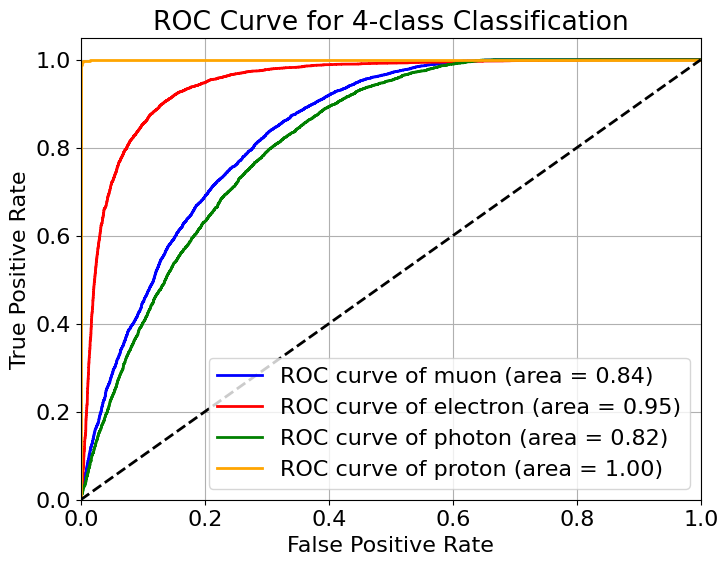

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

particleTypes = ["electron", "muon", "photon", "proton"]
def plot_roc_curve(y_true, y_pred_prob):
    # Binarize the labels
    y_true_binarized = label_binarize(y_true, classes=[0, 1, 2, 3])

    column_sums = np.sum(y_true_binarized, axis=0)
    print(column_sums)
    print(y_true_binarized)
    print(y_pred_prob)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure()
    colors = ['blue', 'red', 'green', 'orange']
    for i, color in zip(range(4), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of {0} (area = {1:0.2f})'
                 ''.format(particleTypes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for 4-class Classification')
    plt.legend(loc="lower right")
    plt.show()

# Example usage
# Replace y_true and y_pred_prob with your actual labels and predicted probabilities
y_target = np.array(y_target)  # Example true labels
y_pred = np.array(y_pred)  # Example predicted probabilities
plot_roc_curve(y_target, y_pred)


# Further Work:
This is our baseline results. It is up to you to investigate other models.

1) CNN: There is an example of a CNN below, with 3 convolution layers into a single fully connected layer. This is loosely based off of AlexNet. You should be able to use this instead of the DenseNN.

2) GNN: Looking at the images, the data is quite sparse. It might be a good idea to represent the data as a graph. Instead of using ParticleImage2D, we can use ParticleImageGraph to represent the cells of the LAr that have an energy deposition. We can then use a graph neural network as our model.

Try both of these to see results. Try your own! Honestly, ChatGPT helped make the CNN and GNN below, maybe you can use it to make a transformer!


# CNN Base:

In [15]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=2, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=2, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        self.conv3 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=2, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        self.fc = nn.Linear(in_features=8 * 24 * 24, out_features=4)  # Adjusted input size

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)  # Max pooling
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)  # Max pooling
        x = torch.relu(self.conv3(x))
        x = self.pool3(x)  # Max pooling
        x = x.view(-1, 8 * 24 * 24)  # Adjusted input size
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


model = CNN()


# GNN Base:

Since we need our data in Graph Form, there is now a class called "ParticleImageGraph" that takes our image of the particle and translates it to a graph, where the nodes are the indivudal pixels of the image, and they are connected if they are next to one another in the original image. You will need to use this rather than the ParticleImage2D class form before

In [16]:
import os
import sys
import h5py
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch_geometric.data import Data
from skimage.transform import resize

class ParticleImageGraph(Dataset):

    def __init__(self, data_files, start=0.0, end=1.0, normalize=None, threshold=0.1):

        self._files = [f if f.startswith('/') else os.path.join(os.getcwd(), f) for f in data_files]
        for f in self._files:
            if os.path.isfile(f): continue
            sys.stderr.write('File not found:%s\n' % f)
            raise FileNotFoundError

        if start < 0. or start > 1.:
            print('start must take a value between 0.0 and 1.0')
            raise ValueError

        if end < 0. or end > 1.:
            print('end must take a value between 0.0 and 1.0')
            raise ValueError

        if end <= start:
            print('end must be larger than start')
            raise ValueError

        self._file_handles = [None] * len(self._files)
        self._entry_to_file_index  = []
        self._entry_to_data_index = []
        self._shape = None
        self.classes = []
        self._normalize = normalize
        self.threshold = threshold
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name, mode='r', swmr=True)
            data_size = f['image'].shape[0]
            if not len(f['pdg']) == data_size:
                print(f['image'].shape, len(f['pdg']))
                raise Exception
            self._entry_to_file_index += [file_index] * data_size
            self._entry_to_data_index += range(data_size)
            self.classes += [pdg for pdg in np.unique(f['pdg'])]
            print(self.classes)
            f.close()

        self.classes = list(np.unique(self.classes))
        self._start  = int(len(self._entry_to_file_index) * start)
        self._length = int(len(self._entry_to_file_index) * end) - self._start

    def __del__(self):
        for i in range(len(self._file_handles)):
            if self._file_handles[i]:
                self._file_handles[i].close()
                self._file_handles[i] = None

    def __len__(self):
        return self._length

    def __getitem__(self, idx):
        file_index  = self._entry_to_file_index[self._start + idx]
        entry_index = self._entry_to_data_index[self._start + idx]
        if self._file_handles[file_index] is None:
            self._file_handles[file_index] = h5py.File(self._files[file_index], mode='r', swmr=True)

        fh = self._file_handles[file_index]

        data = torch.Tensor(fh['image'][entry_index])
        if self._normalize:
            data = (data - self._normalize[0]) / self._normalize[1]

        active_pixels = data.numpy() > self.threshold
        height, width = active_pixels.shape
        node_features = []
        edge_index = []

        pos_to_idx = {}
        idx = 0
        for x in range(height):
            for y in range(width):
                if active_pixels[x, y]:
                    pos_to_idx[x, y] = idx
                    node_features.append([data[x, y].item()])
                    idx += 1

        def add_edges(x, y):
            if x > 0 and active_pixels[x-1, y]:
                edge_index.append([pos_to_idx[x, y], pos_to_idx[x-1, y]])
            if x < height-1 and active_pixels[x+1, y]:
                edge_index.append([pos_to_idx[x, y], pos_to_idx[x+1, y]])
            if y > 0 and active_pixels[x, y-1]:
                edge_index.append([pos_to_idx[x, y], pos_to_idx[x, y-1]])
            if y < width-1 and active_pixels[x, y+1]:
                edge_index.append([pos_to_idx[x, y], pos_to_idx[x, y+1]])

        for x in range(height):
            for y in range(width):
                if active_pixels[x, y]:
                    add_edges(x, y)

        node_features = torch.tensor(node_features, dtype=torch.float)
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

        label, pdg = None, None
        if 'pdg' in fh:
            pdg = fh['pdg'][entry_index]
            label = self.classes.index(pdg)

        return Data(x=node_features, edge_index=edge_index, y=torch.tensor([label]))

def collate(batch):
    return batch


In [17]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GNN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # Global pooling to get graph-level representation
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


